## CS 7641 Machine Learning
## Assignment 3 Unsupervised Learning and Dimensional Deduction
#### Experiment: Step 1 Clustering Algorithms
#### Algorithms: Expectation Maximization & KMeans
#### Data      : Dropout & AIDS

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import math

from scipy.stats import kurtosis 

from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import FastICA, PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import SparseRandomProjection


from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
#from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Predict Students' Dropout and Academic Success
## Clustering Algorithm (KMeans)

In [2]:
##
## Data Load
##

df = pd.read_csv("./data/dropout.csv", sep=";")

# Target 데이터 분석 및 제거
num_droupout = df.query('Target=="Dropout"')
num_enrolled = df.query('Target=="Enrolled"')
num_graduated = df.query('Target=="Graduate"')

# Enrolled 데이타 삭제 (pending)
df = df.drop(df[df['Target'] == "Enrolled"].index)

# pandas dataframe replace (from https://heytech.tistory.com/441)
df["Target"].replace({'Dropout':0, 'Graduate':1}, inplace = True)

X_raw = df.values[:,:-1]
y_raw = df.values[:,-1]

Text(0, 0.5, 'Scores')

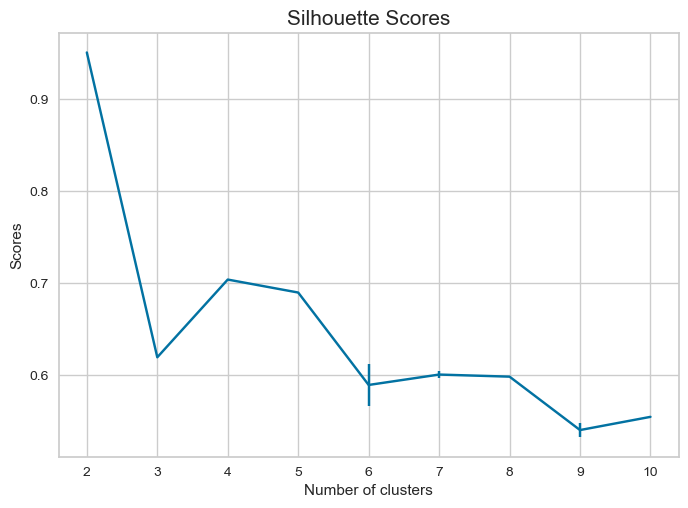

In [3]:
##
## Silhouette Coefficient (KMeans)
## https://studying-haeung.tistory.com/13
##

num_clusters = 10 # the maximum number of clusters
model = KMeans    # clustering algorithm

list_clusters=np.arange(2, num_clusters+1)
silhouettes=[]
silhouettes_errors=[]
iterations=num_clusters+1

for n in list_clusters:
    silhouettes_tmp=[]
    for _ in range(iterations):
        classifier=model(n).fit(X_raw) 
        y_pred=classifier.predict(X_raw)
        silhouette=metrics.silhouette_score(X_raw, y_pred, metric='euclidean')
        silhouettes_tmp.append(silhouette)
    temp = np.array(silhouettes_tmp)
    mean=np.mean(temp[np.argsort(temp)[:int(iterations/5)]])
    std=np.std(silhouettes_tmp)
    silhouettes.append(mean)
    silhouettes_errors.append(std)

plt.errorbar(list_clusters, silhouettes, yerr=silhouettes_errors)
plt.title("Silhouette Scores", fontsize=15)
plt.xticks(list_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scores")

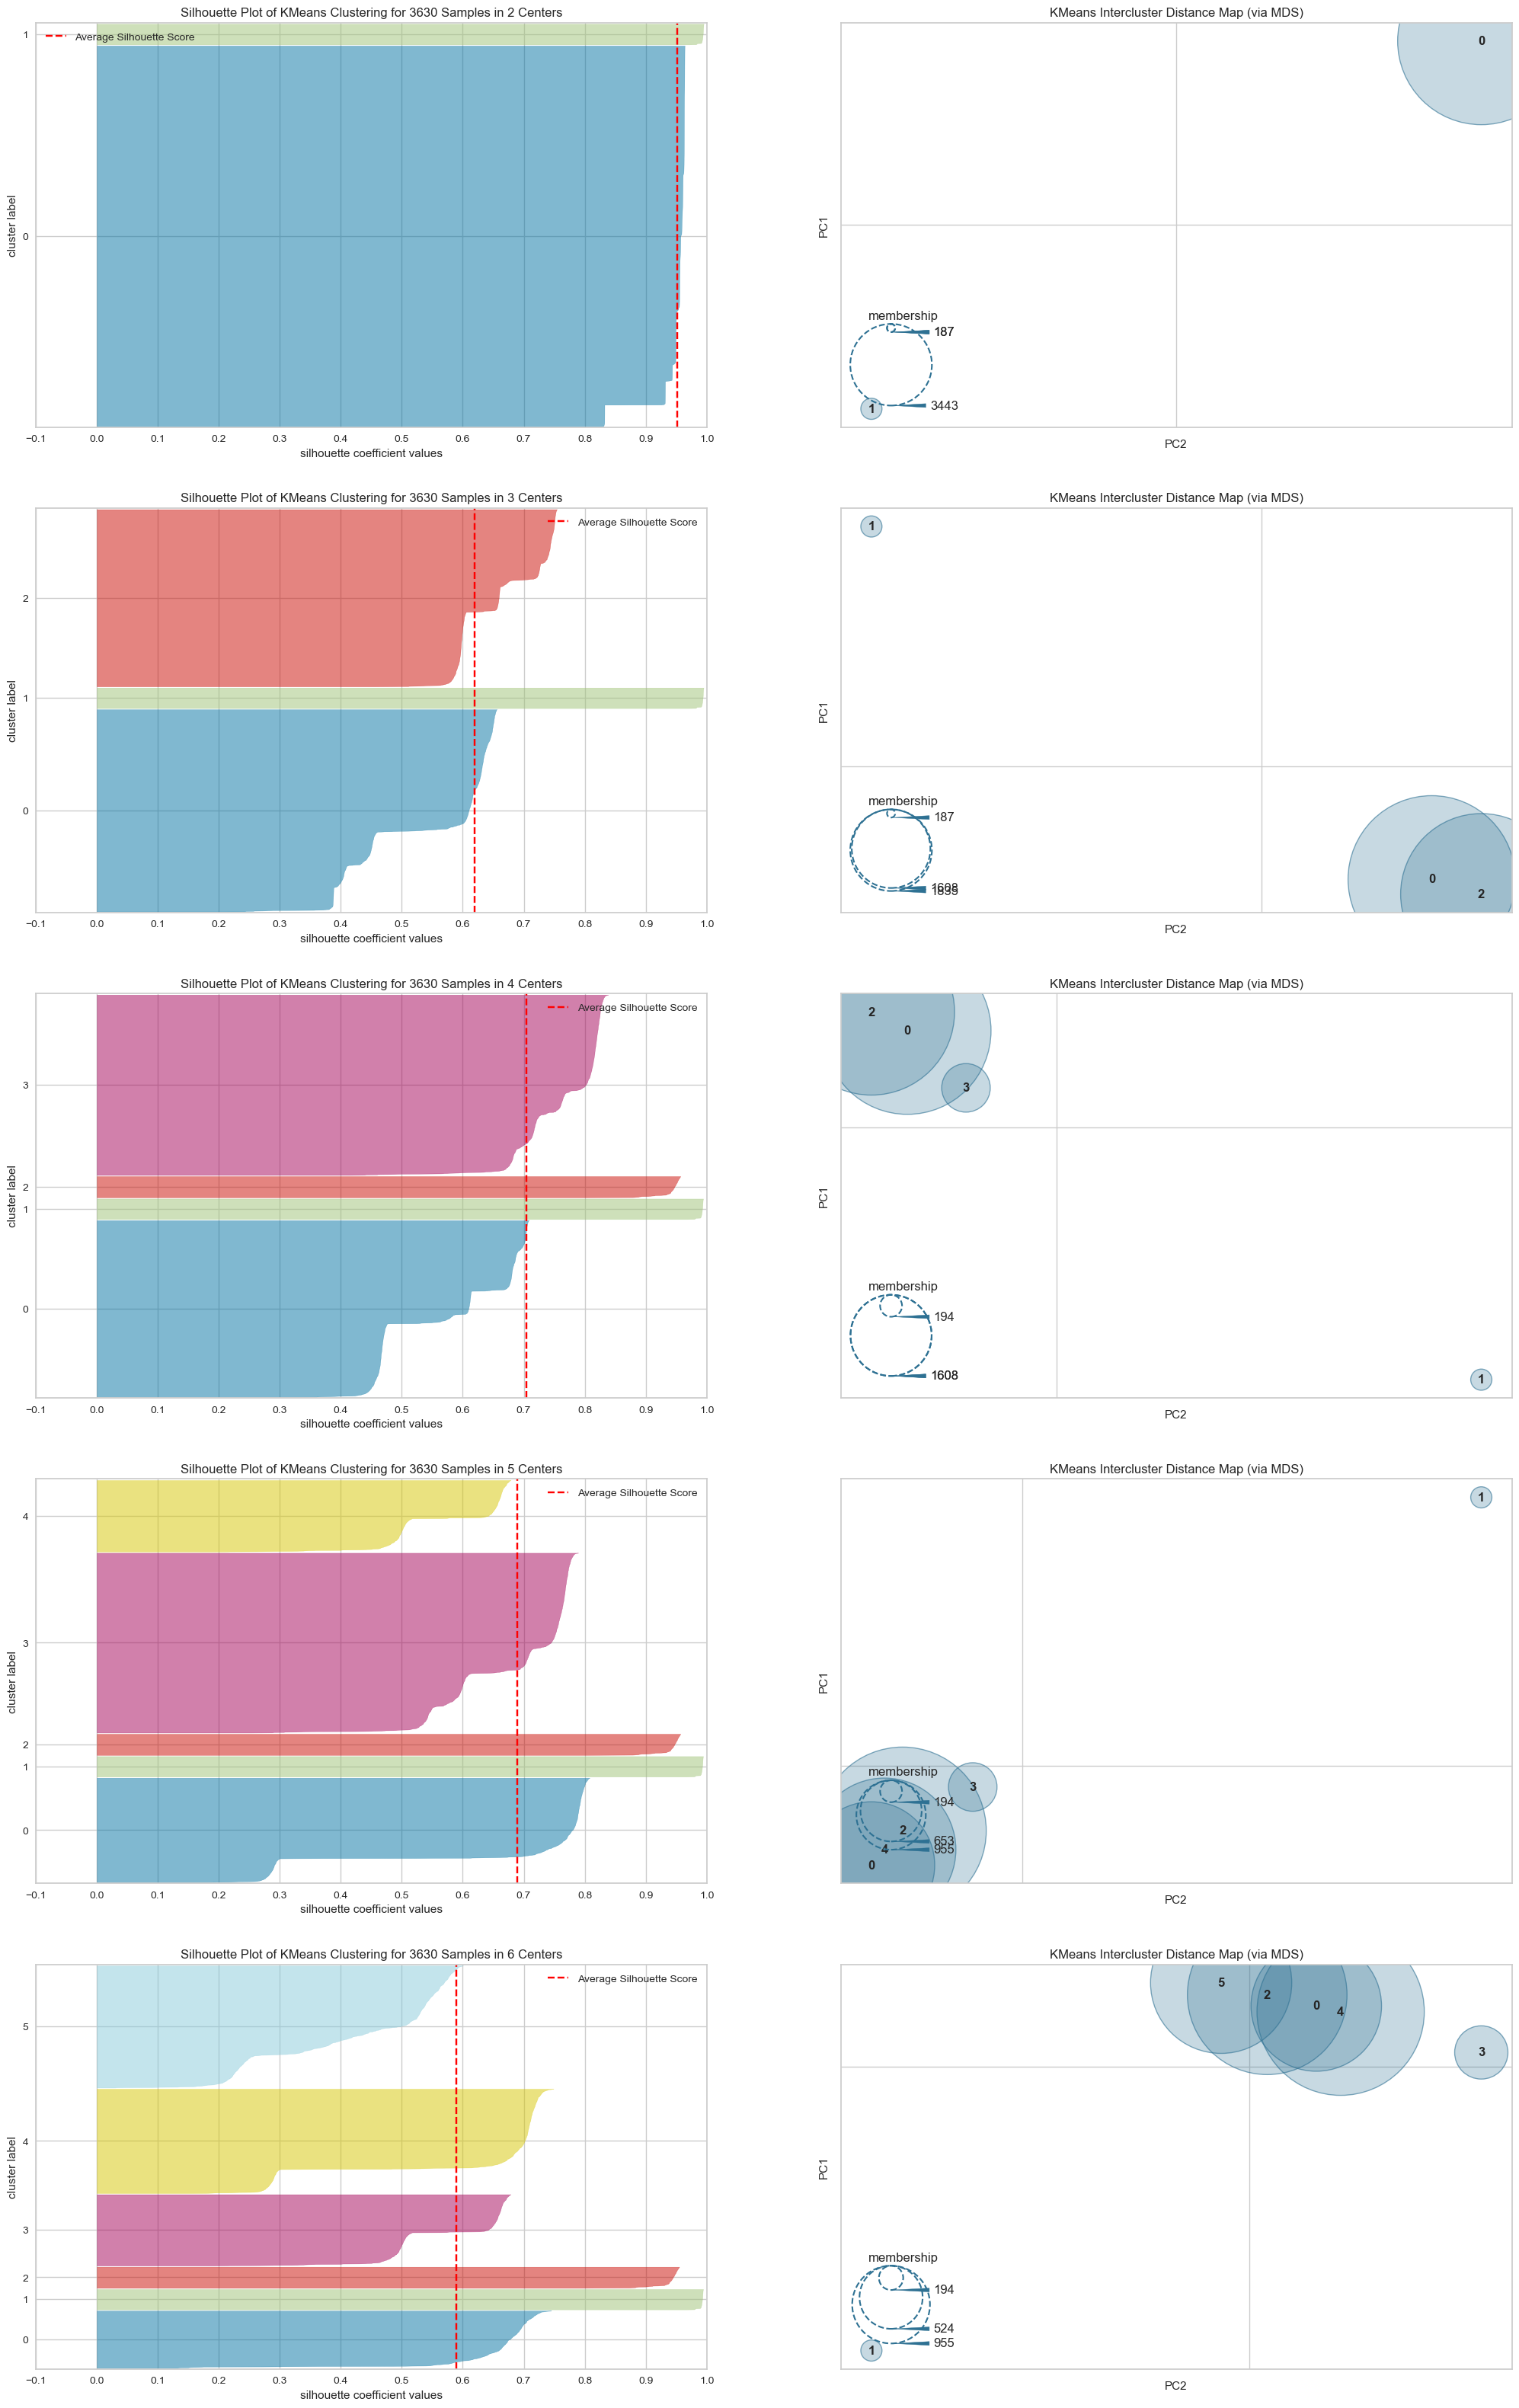

In [4]:
##
## SilhouetteVisualizer & InterclusterDistance (KMeans)
##

num_clusters = 6  # the maximum number of clusters
model = KMeans    # clustering algorithm

list_clusters = list(range(2, num_clusters+1))
num_plots = len(list_clusters)
fig, axes = plt.subplots(num_plots, 2, figsize=[25,40])
col_ = 0
for i in list_clusters:
    classifier = model(n_clusters=i, algorithm="full")
    visualizer = SilhouetteVisualizer(classifier, colors='yellowbrick', ax=axes[col_][0])
    visualizer.fit(X_raw)
    visualizer.finalize()
        
    classifier = model(n_clusters=i, algorithm="full")
    visualizer = InterclusterDistance(classifier, ax=axes[col_][1])
    visualizer.fit(X_raw)
    visualizer.finalize()
        
    col_+=1
plt.show()

In [10]:
## 
## KMeans Training Time and Accuracy
## 

num_clusters = 2

# Training Time
start_time = time.perf_counter()
model = KMeans(n_clusters= num_clusters).fit(X_raw)
training_time = time.perf_counter() - start_time
print("Training Time: ", training_time)

# Accuracy
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2)

classifier = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 3)
cross_score = cross_val_score(classifier, X_train, y_train, cv=5).mean()
print("Cross Validation Score: " + str(cross_score))

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy: " + str(accuracy_score))

Training Time:  0.1925106670241803
Cross Validation Score: 0.8567475814588402
Test Accuracy: 0.8539944903581267


## Expectation Maximization (GaussianMixture)

Text(0, 0.5, 'Scores')

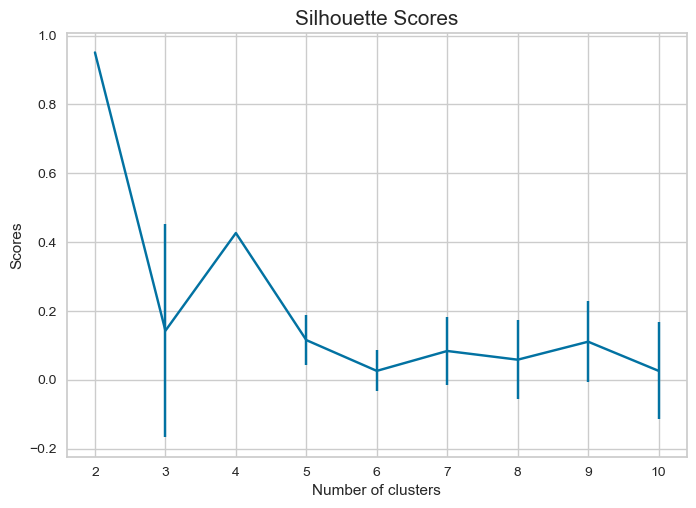

In [9]:
##
## Silhouette Coefficient (Gaussian Mixture)
## https://studying-haeung.tistory.com/13
##

num_clusters = 10 # the maximum number of clusters
model = GaussianMixture    # clustering algorithm

list_clusters=np.arange(2, num_clusters+1)
silhouettes=[]
silhouettes_errors=[]
iterations=num_clusters+1

for n in list_clusters:
    silhouettes_tmp=[]
    for _ in range(iterations):
        classifier=model(n).fit(X_raw) 
        y_pred=classifier.predict(X_raw)
        silhouette=metrics.silhouette_score(X_raw, y_pred, metric='euclidean')
        silhouettes_tmp.append(silhouette)
    temp = np.array(silhouettes_tmp)
    mean=np.mean(temp[np.argsort(temp)[:int(iterations/5)]])
    std=np.std(silhouettes_tmp)
    silhouettes.append(mean)
    silhouettes_errors.append(std)
plt.errorbar(list_clusters, silhouettes, yerr=silhouettes_errors)
plt.title("Silhouette Scores", fontsize=15)
plt.xticks(list_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scores")

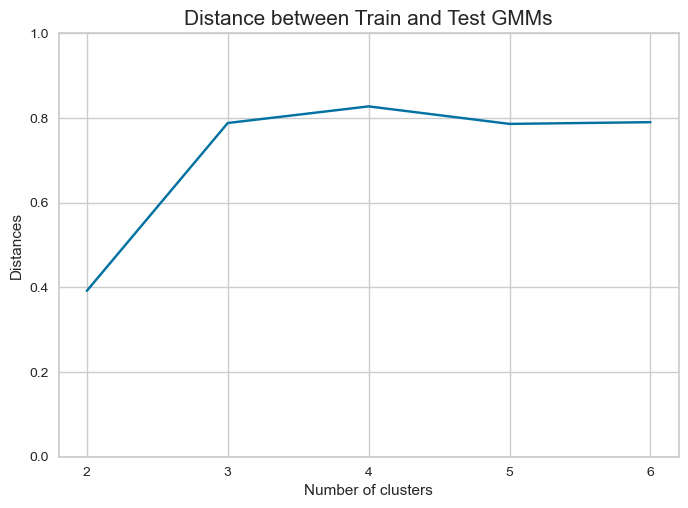

In [20]:
##
## Distance between GMMs (Gaussian Mixture)
## https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4    
##

# https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
def gmm_js(gmm_p, gmm_q, n_samples=10**5):

    # Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

num_clusters = 6  # the maximum number of clusters
model = KMeans    # clustering algorithm

list_clusters = list(range(2, num_clusters+1))
iterations=num_clusters+1
results=[]
results_signs=[]

for n in list_clusters:
    dists=[]

    for iteration in range(iterations):
        train, test=train_test_split(X_raw, test_size=0.5)
        train_gmm=GaussianMixture(n, n_init=2).fit(train) 
        test_gmm=GaussianMixture(n, n_init=2).fit(test) 
        dists.append(gmm_js(train_gmm, test_gmm))
    temp = np.array(np.array(dists))
    sel = temp[np.argsort(temp)[:int(iterations/5)]]
    result = np.mean(sel)
    result_sign = np.std(sel)

    results.append(result)
    results_signs.append(result_sign)

plt.errorbar(list_clusters, results, yerr=results_signs)
plt.title("Distance between Train and Test GMMs", fontsize=15)
plt.xticks(list_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Distances")
plt.ylim(0, 1)
plt.show()

In [12]:
## 
## EM Training Time and Accuracy
## 

num_clusters = 2

# Training Time
start_time = time.perf_counter()
model = GaussianMixture(n_components= num_clusters).fit(X_raw)
training_time = time.perf_counter() - start_time
print("Training Time: ", training_time)

# Accuracy
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2)

classifier = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 3)
cross_score = cross_val_score(classifier, X_train, y_train, cv=5).mean()
print("Cross Validation Score: " + str(cross_score))

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy: " + str(accuracy_score))

Training Time:  0.1731107080122456
Cross Validation Score: 0.8595008605851978
Test Accuracy: 0.8457300275482094


## AIDS Clinical Trials Group Stury 175
## Clustering Algorithm (KMeans)

In [15]:
#
# data: AIDS Clinical Trials Group Study 175
# source: https://archive.ics.uci.edu/dataset/890/aids+clinical+trials+group+study+175

#
# Start Loading Data
# Using the provided method from UDI ()
# Pakcage Installation needed
# pip install ucimlrepo
# 

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
  
# data (as pandas dataframes) 
X = aids_clinical_trials_group_study_175.data.features 
y = aids_clinical_trials_group_study_175.data.targets 

#
# End Loading Data
#

In [16]:
y=y.cid

X_raw = X
y_raw = y

Text(0, 0.5, 'Scores')

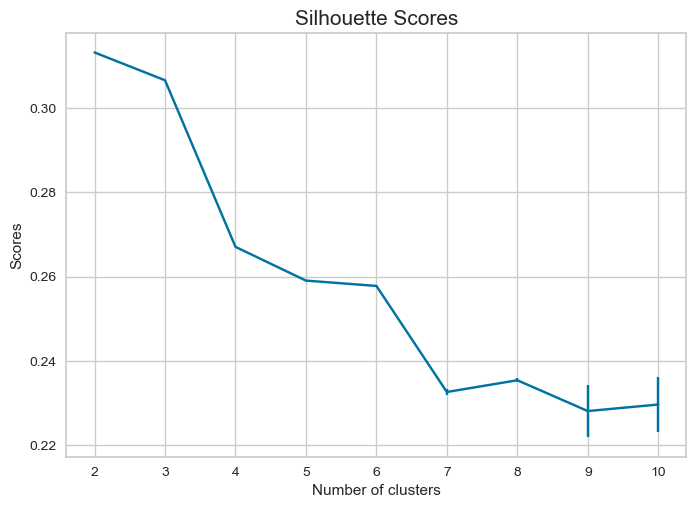

In [26]:
##
## Silhouette Coefficient (KMeans)
## https://studying-haeung.tistory.com/13
##

num_clusters = 10 # the maximum number of clusters
model = KMeans    # clustering algorithm

list_clusters=np.arange(2, num_clusters+1)
silhouettes=[]
silhouettes_errors=[]
iterations=num_clusters+1

for n in list_clusters:
    silhouettes_tmp=[]
    for _ in range(iterations):
        classifier=model(n).fit(X_raw) 
        y_pred=classifier.predict(X_raw)
        silhouette=metrics.silhouette_score(X_raw, y_pred, metric='euclidean')
        silhouettes_tmp.append(silhouette)
    temp = np.array(silhouettes_tmp)
    mean=np.mean(temp[np.argsort(temp)[:int(iterations/5)]])
    std=np.std(silhouettes_tmp)
    silhouettes.append(mean)
    silhouettes_errors.append(std)

plt.errorbar(list_clusters, silhouettes, yerr=silhouettes_errors)
plt.title("Silhouette Scores", fontsize=15)
plt.xticks(list_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scores")

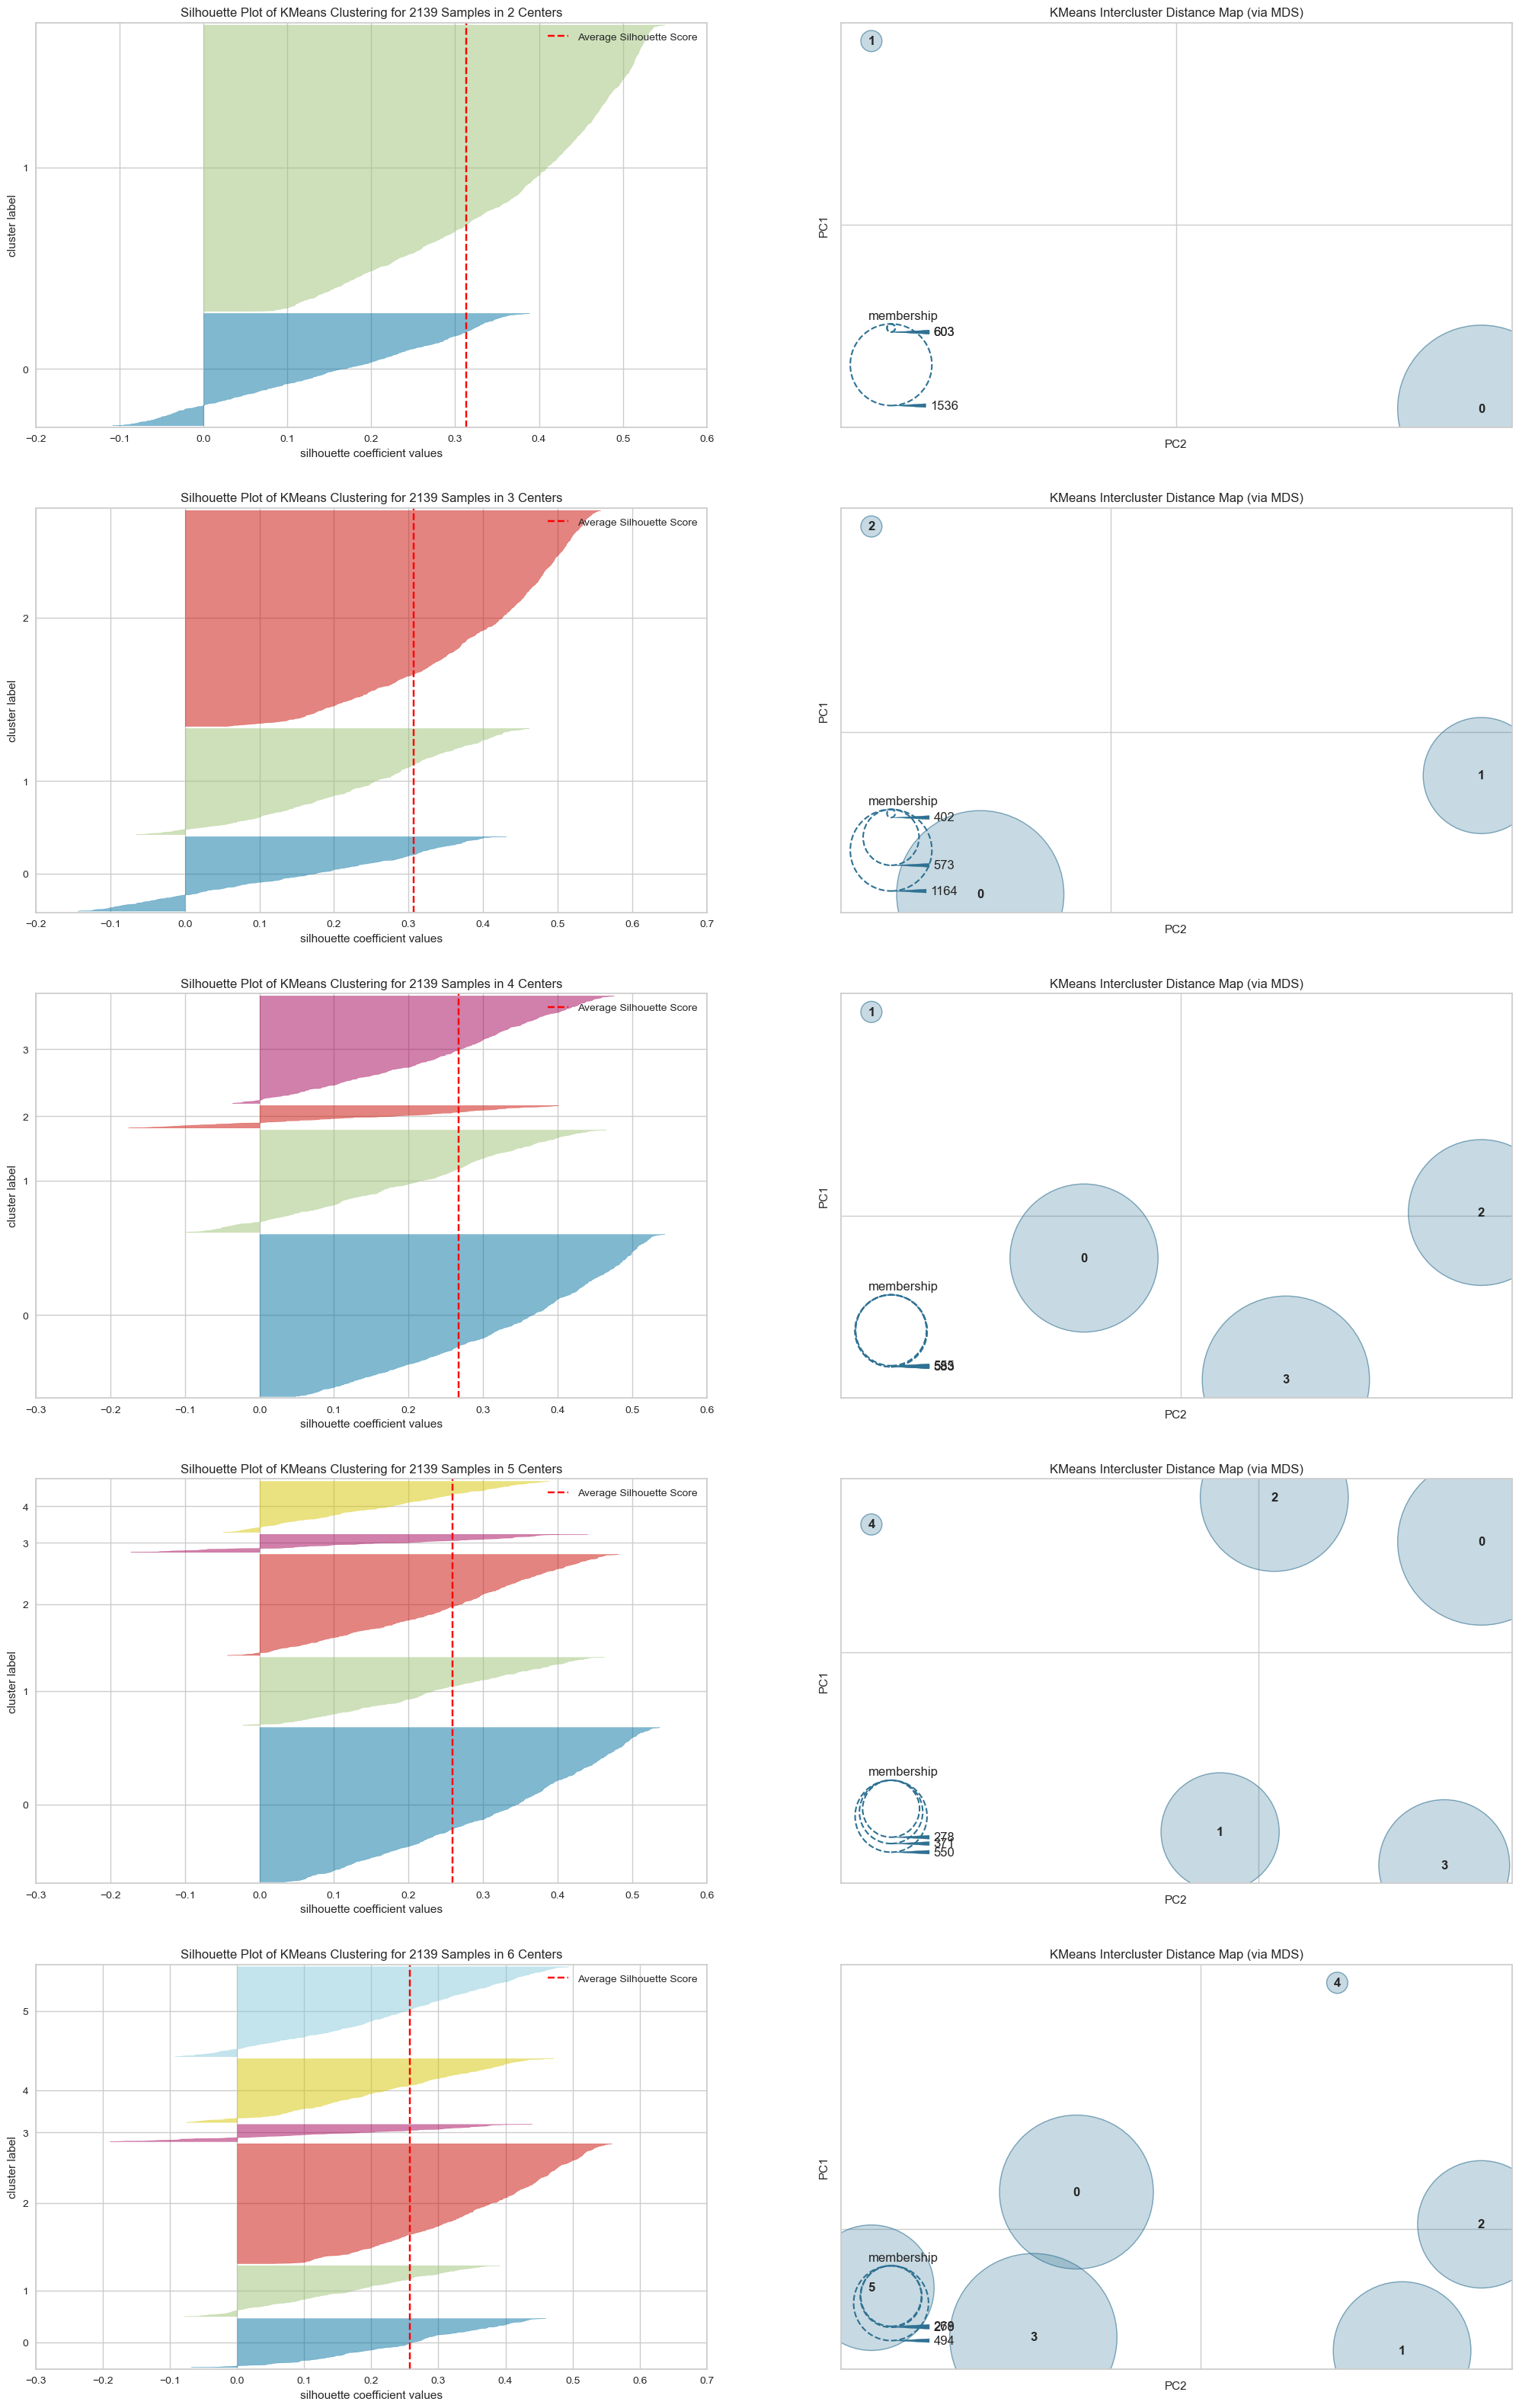

In [27]:
##
## SilhouetteVisualizer & InterclusterDistance (KMeans)
##

num_clusters = 6  # the maximum number of clusters
model = KMeans    # clustering algorithm

list_clusters = list(range(2, num_clusters+1))
num_plots = len(list_clusters)
fig, axes = plt.subplots(num_plots, 2, figsize=[25,40])
col_ = 0
for i in list_clusters:
    classifier = model(n_clusters=i, algorithm="full")
    visualizer = SilhouetteVisualizer(classifier, colors='yellowbrick', ax=axes[col_][0])
    visualizer.fit(X_raw)
    visualizer.finalize()
        
    classifier = model(n_clusters=i, algorithm="full")
    visualizer = InterclusterDistance(classifier, ax=axes[col_][1])
    visualizer.fit(X_raw)
    visualizer.finalize()
        
    col_+=1
plt.show()

In [17]:
## 
## KMeans Training Time and Accuracy
## 

num_clusters = 2

# Training Time
start_time = time.perf_counter()
model = KMeans(n_clusters= num_clusters).fit(X_raw)
training_time = time.perf_counter() - start_time
print("Training Time: ", training_time)

# Accuracy
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2)

classifier = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 3)
cross_score = cross_val_score(classifier, X_train, y_train, cv=5).mean()
print("Cross Validation Score: " + str(cross_score))

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy: " + str(accuracy_score))

Training Time:  0.206012916052714
Cross Validation Score: 0.8340101955569195
Test Accuracy: 0.8644859813084113


## Expectation Maximization (GaussianMixture)

Text(0, 0.5, 'Scores')

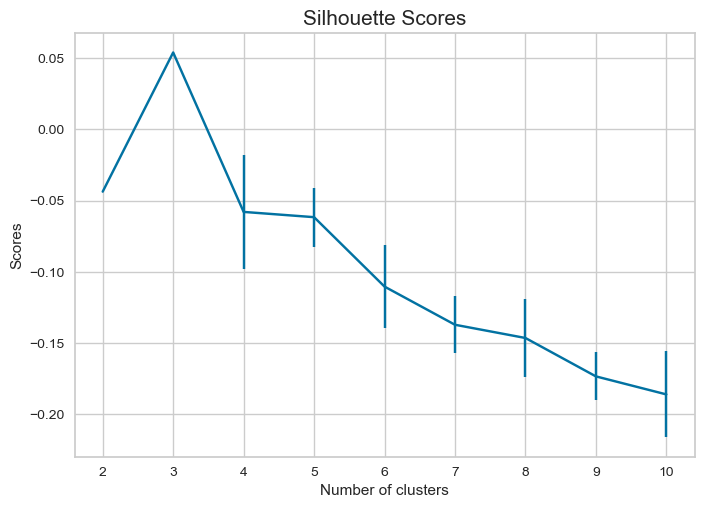

In [28]:
##
## Silhouette Coefficient (Gaussian Mixture)
## https://studying-haeung.tistory.com/13
##

num_clusters = 10 # the maximum number of clusters
model = GaussianMixture    # clustering algorithm

list_clusters=np.arange(2, num_clusters+1)
silhouettes=[]
silhouettes_errors=[]
iterations=num_clusters+1

for n in list_clusters:
    silhouettes_tmp=[]
    for _ in range(iterations):
        classifier=model(n).fit(X_raw) 
        y_pred=classifier.predict(X_raw)
        silhouette=metrics.silhouette_score(X_raw, y_pred, metric='euclidean')
        silhouettes_tmp.append(silhouette)
    temp = np.array(silhouettes_tmp)
    mean=np.mean(temp[np.argsort(temp)[:int(iterations/5)]])
    std=np.std(silhouettes_tmp)
    silhouettes.append(mean)
    silhouettes_errors.append(std)
plt.errorbar(list_clusters, silhouettes, yerr=silhouettes_errors)
plt.title("Silhouette Scores", fontsize=15)
plt.xticks(list_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scores")

/Users/hsohn/miniconda3/envs/cs7641-a3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/hsohn/miniconda3/envs/cs7641-a3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/hsohn/miniconda3/envs/cs7641-a3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/hsohn/miniconda3/envs/cs7641-a3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/hsohn/miniconda3/envs/cs7641-a3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with f

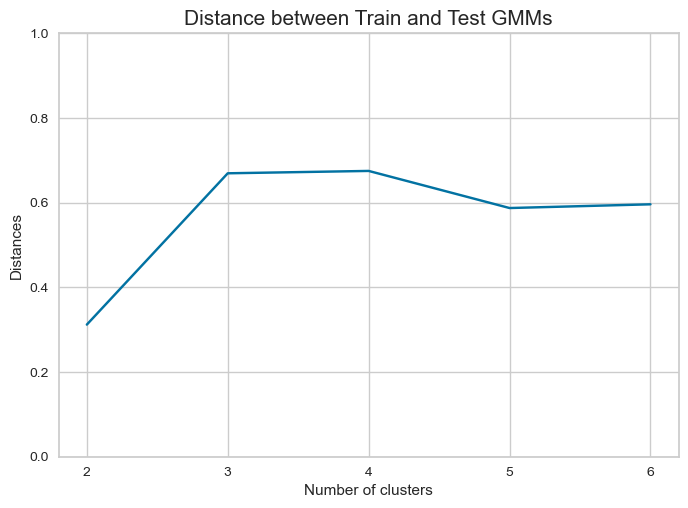

In [29]:
##
## Distance between GMMs (Gaussian Mixture)
## https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4    
##

# https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
def gmm_js(gmm_p, gmm_q, n_samples=10**5):

    # Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

num_clusters = 6  # the maximum number of clusters
model = KMeans    # clustering algorithm

list_clusters = list(range(2, num_clusters+1))
iterations=num_clusters+1
results=[]
results_signs=[]

for n in list_clusters:
    dists=[]

    for iteration in range(iterations):
        train, test=train_test_split(X_raw, test_size=0.5)
        train_gmm=GaussianMixture(n, n_init=2).fit(train) 
        test_gmm=GaussianMixture(n, n_init=2).fit(test) 
        dists.append(gmm_js(train_gmm, test_gmm))
    temp = np.array(np.array(dists))
    sel = temp[np.argsort(temp)[:int(iterations/5)]]
    result = np.mean(sel)
    result_sign = np.std(sel)

    results.append(result)
    results_signs.append(result_sign)

plt.errorbar(list_clusters, results, yerr=results_signs)
plt.title("Distance between Train and Test GMMs", fontsize=15)
plt.xticks(list_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Distances")
plt.ylim(0, 1)
plt.show()

In [18]:
## 
## EM Training Time and Accuracy
## 

num_clusters = 2

# Training Time
start_time = time.perf_counter()
model = GaussianMixture(n_components= num_clusters).fit(X_raw)
training_time = time.perf_counter() - start_time
print("Training Time: ", training_time)

# Accuracy
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2)

classifier = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 3)
cross_score = cross_val_score(classifier, X_train, y_train, cv=5).mean()
print("Cross Validation Score: " + str(cross_score))

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy: " + str(accuracy_score))

Training Time:  0.14659491693601012
Cross Validation Score: 0.8644093226262937
Test Accuracy: 0.8574766355140186
